# Load the data

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt
# import joblib

In [5]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.0051, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [6]:
data_train_raw.shape

(188318, 132)

# Data EDA and Transformation

In [7]:
def lossRescale(logloss,ymean,ystd):
    loss = (logloss-ymean)/ystd
    return loss
def lossRestore(logloss, ymean, ystd):
    loss = np.exp(logloss*ystd+ymean)
    return loss

In [8]:
shift=200
colLabel = 'logloss'
colRawLabel = 'loss'
labelColumns = [colLabel, colRawLabel]
data_train_raw[colLabel]=np.log(data_train_raw[colRawLabel]+shift)
print('Skewness of raw loss values: {}'.format(data_train_raw[colRawLabel].skew()))
print('Skewness of log1p loss values: {}'.format(data_train_raw[colLabel].skew()))

Skewness of raw loss values: 3.79495837754
Skewness of log1p loss values: 0.301411340599


In [9]:
# ymean=0
# ystd=1
ymean=data_train_raw[colLabel].min()
ystd=(data_train_raw[colLabel]-ymean).max()
data_train_raw[colLabel]=lossRescale(data_train_raw[colLabel],ymean,ystd)

In [7]:
# clean outliers in training data
rescaledMean = data_train_raw[colLabel].mean()
rescaledStd = data_train_raw[colLabel].std()
print('Mean of rescaled log1py: {}'.format(rescaledMean))
print('Std of rescaled log1py: {}'.format(rescaledMean))

lbound = rescaledMean-3*rescaledStd
ubound = rescaledMean+3*rescaledStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw[colLabel]>=lbound) & (data_train_raw[colLabel]<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))
print('Skewness of clipped log1p loss: {}'.format(data_train_raw[colLabel].skew()))

Mean of rescaled log1py: 0.390118205749
Std of rescaled log1py: 0.390118205749
Lower clipping bound: 0.047397382357
Upper clipping bound: 0.732839029142
Shape of cleaned data: (187995, 133)
Skewness of clipped log1p loss: 0.26876327248


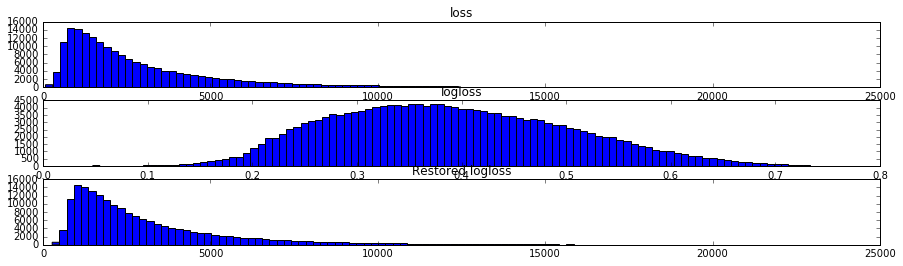

In [8]:
plt.figure(figsize=(15,4))

plt.subplot(3,1,1)
plt.hist(data_train_raw[colRawLabel],100)
plt.title(colRawLabel);
plt.subplot(3,1,2)
plt.hist(data_train_raw[colLabel],100)
plt.title(colLabel);
plt.subplot(3,1,3)
plt.hist(lossRestore(data_train_raw[colLabel],ymean,ystd),100)
plt.title('Restored '+colLabel);

In [9]:
print('Are there any null values?')
print(data_train_raw.isnull().any().any())
print(data_test_raw.isnull().any().any())

Are there any null values?
False
False


In [10]:
print('Logarithmic transformed, rescaled, clipped loss:')
data_train_raw[colLabel].describe()

Logarithmic transformed, rescaled, clipped loss:


count    187995.000000
mean          0.389583
std           0.113253
min           0.047403
25%           0.303756
50%           0.381712
75%           0.469298
max           0.732815
Name: logloss, dtype: float64

# Data preparation - labeling cat features with ordinal information encoded

In [11]:
# save label in a seperate serie
labelSs = data_train_raw[colLabel]
labelColumns.append('id')
trainDf = data_train_raw.drop(labelColumns,axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has {} features from the raw data:\n{}'.format(len(trainDf), trainDf.columns))
print('testDf has {} features from the raw data:\n{}'.format(len(testDf),testDf.columns))

trainDf has 187995 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has 125546 features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [12]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313541, 130)
(313541, 116) of which are categorical
(313541, 14) of which are continuous


In [13]:
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,A,B,A,B,A,A,A,A,B,A,...,J,G,BU,BC,C,AS,S,A,O,LB
1,A,B,A,A,A,A,A,A,B,B,...,K,K,BI,CQ,A,AV,BM,A,O,DP
2,A,B,A,A,B,A,A,A,B,B,...,F,A,AB,DK,A,C,AF,A,I,GK
3,B,B,A,B,A,A,A,A,B,A,...,K,K,BI,CS,C,N,AE,A,O,DJ
4,A,B,A,B,A,A,A,A,B,B,...,G,B,H,C,C,Y,BM,A,K,CK


In [14]:
LevelList = {'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'}
# def LetterRep(x,LevelList):
#     if x in LevelList:
#         x = '0'+x
#     return x
    
def LetterRep(x,LevelList):
    if x in LevelList:
        x = '0'+x
    return x

dataCatAll = dataCatAll.applymap(lambda x: LetterRep(x,LevelList))
dataCatAll.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0A,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0J,0G,BU,BC,0C,AS,0S,0A,0O,LB
1,0A,0B,0A,0A,0A,0A,0A,0A,0B,0B,...,0K,0K,BI,CQ,0A,AV,BM,0A,0O,DP
2,0A,0B,0A,0A,0B,0A,0A,0A,0B,0B,...,0F,0A,AB,DK,0A,0C,AF,0A,0I,GK
3,0B,0B,0A,0B,0A,0A,0A,0A,0B,0A,...,0K,0K,BI,CS,0C,0N,AE,0A,0O,DJ
4,0A,0B,0A,0B,0A,0A,0A,0A,0B,0B,...,0G,0B,0H,0C,0C,0Y,BM,0A,0K,CK


In [15]:
features = dataCatAll.columns[0:]
cats = [feature for feature in features if feature.startswith('cat')]
for feat in cats:
    dataCatAll[feat] = pd.factorize(dataCatAll[feat], sort=True)[0]
dataCatAll.head()
# le.classes_

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
0,0,1,0,1,0,0,0,0,1,0,...,9,6,68,49,2,43,17,0,14,299
1,0,1,0,0,0,0,0,0,1,1,...,10,10,56,87,0,46,60,0,14,114
2,0,1,0,0,1,0,0,0,1,1,...,5,0,25,106,0,2,28,0,8,184
3,1,1,0,1,0,0,0,0,1,0,...,10,10,56,89,2,13,27,0,14,108
4,0,1,0,1,0,0,0,0,1,1,...,6,1,7,2,2,24,60,0,10,84


In [16]:
# rescale the labeled categorical data
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
x_catAll = mms.fit_transform(dataCatAll)

In [17]:
print(x_catAll.shape)
x_catAll

(313541, 116)


array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.86416185],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.63636364,  0.32947977],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.36363636,  0.53179191],
       ..., 
       [ 1.        ,  1.        ,  0.        , ...,  0.        ,
         0.68181818,  0.93063584],
       [ 0.        ,  0.        ,  0.        , ...,  0.22222222,
         0.63636364,  0.31213873],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
         0.5       ,  0.26300578]])

# one-hot-encoding - skipped in order to keep the alphabetical order

In [18]:
# # one-hot-encoding the categorical features
# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder()
# x_catAll = enc.fit_transform(dataCatAll)
# print(x_catAll.shape)

# split x_train and x_test

In [19]:
# split x_train and x_test
x_train = sp.sparse.hstack((x_catAll[0:len(labelSs),:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_test = sp.sparse.hstack((x_catAll[len(labelSs):,:],sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_train = labelSs.values

# check the dimension of prepared data

In [20]:
print(x_test.shape)
print(x_train.shape)
print(y_train.shape)

(125546, 130)
(187995, 130)
(187995,)


# splite the training data for valication

In [21]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_train, y_train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(150396, 130)
(150396,)
(37599, 130)
(37599,)


In [22]:
# del x_Train
# del y_Train
# del x_catAll
# del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [24]:
seed = 0
testList = ['AdaBoosting', 'MLPRegressor','XGBoostTrees']
modelList = []

### AdaBoost

In [25]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge

In [26]:
adbParamGrid = { 'n_estimators': 5   #[5,10,25,40,80], \
                 'learning_rate':[1e-1], \
#                  'loss':['linear', 'square','exponential']}
                 'loss':['exponential']}
# DTR = DecisionTreeRegressor(criterion='mae')
# base_estimator = DecisionTreeRegressor()
base_estimator = Ridge(alpha = 40,random_state=seed)

In [27]:
# clf = GridSearchCV(AdaBoostRegressor(random_state=seed), adbParamGrid, scoring = 'neg_mean_absolute_error', \
#                    n_jobs=-1, refit=True)
clf = GridSearchCV(AdaBoostRegressor(base_estimator=base_estimator,random_state=seed), adbParamGrid, scoring = 'neg_mean_absolute_error', \
                   n_jobs=7, refit=True)

clf.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=AdaBoostRegressor(base_estimator=Ridge(alpha=40, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=0, solver='auto', tol=0.001),
         learning_rate=1.0, loss='linear', n_estimators=50, random_state=0),
       fit_params={}, iid=True, n_jobs=7,
       param_grid={'n_estimators': [5, 10, 25, 40, 80], 'loss': ['exponential'], 'learning_rate': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [28]:
print("best params: " + str(clf.best_params_))
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std(), params))
    print(scores)

best params: {'n_estimators': 5, 'loss': 'exponential', 'learning_rate': 0.1}
-0.064 (+/-0.000) for {'n_estimators': 5, 'loss': 'exponential', 'learning_rate': 0.1}
[-0.06343314 -0.06380594 -0.06388446]
-0.064 (+/-0.000) for {'n_estimators': 10, 'loss': 'exponential', 'learning_rate': 0.1}
[-0.06344947 -0.06383659 -0.06390158]
-0.064 (+/-0.000) for {'n_estimators': 25, 'loss': 'exponential', 'learning_rate': 0.1}
[-0.06360348 -0.06397577 -0.0640466 ]
-0.064 (+/-0.000) for {'n_estimators': 40, 'loss': 'exponential', 'learning_rate': 0.1}
[-0.06385693 -0.06417331 -0.06424088]
-0.065 (+/-0.000) for {'n_estimators': 80, 'loss': 'exponential', 'learning_rate': 0.1}
[-0.06485455 -0.0648261  -0.06503835]


/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [29]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(clf.predict(x_val),ymean,ystd)))

1249.24446123


In [30]:
y_pred_i = clf.predict(x_test)
y_pred.append(y_pred_i)
y_pred_val.append(clf.predict(x_val))
modelList.append(clf)

### MLP

In [31]:
from sklearn.neural_network import MLPRegressor

In [32]:
mlpParamGrid = { 'hidden_layer_sizes':[(20,2),(35,2),(50,2),(80,2),(100,2),(20,3),(35,3),(50,3),(80,3),(100,3)],
                 'activation':['tanh'],
#                  'tol':[1e-4,1e-3,1e-2, 1e-1, 1e0, 1e1]
               }

In [33]:
clf = GridSearchCV(MLPRegressor(random_state=seed,early_stopping=True,max_iter=400,tol=0.0001), mlpParamGrid,                
                   n_jobs=7, refit=True,cv=5, scoring = 'neg_mean_absolute_error')
clf.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
       fit_params={}, iid=True, n_jobs=7,
       param_grid={'activation': ['tanh'], 'hidden_layer_sizes': [(20, 2), (35, 2), (50, 2), (80, 2), (100, 2), (20, 3), (35, 3), (50, 3), (80, 3), (100, 3)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [34]:
print("best params: " + str(clf.best_params_))
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std(), params))
    print(scores)

best params: {'activation': 'tanh', 'hidden_layer_sizes': (20, 3)}
-0.061 (+/-0.000) for {'activation': 'tanh', 'hidden_layer_sizes': (20, 2)}
[-0.06006546 -0.06087616 -0.06088165 -0.06079466 -0.06085727]
-0.061 (+/-0.000) for {'activation': 'tanh', 'hidden_layer_sizes': (35, 2)}
[-0.06074963 -0.06139254 -0.06081653 -0.06071434 -0.06144341]
-0.062 (+/-0.001) for {'activation': 'tanh', 'hidden_layer_sizes': (50, 2)}
[-0.06002478 -0.06101653 -0.06324554 -0.06268069 -0.06081918]
-0.061 (+/-0.000) for {'activation': 'tanh', 'hidden_layer_sizes': (80, 2)}
[-0.06004834 -0.06070792 -0.06056548 -0.06104947 -0.06110909]
-0.061 (+/-0.001) for {'activation': 'tanh', 'hidden_layer_sizes': (100, 2)}
[-0.06038063 -0.06191028 -0.06131993 -0.06072495 -0.0611426 ]
-0.060 (+/-0.000) for {'activation': 'tanh', 'hidden_layer_sizes': (20, 3)}
[-0.05998491 -0.06083904 -0.06084915 -0.06032629 -0.06041632]
-0.061 (+/-0.000) for {'activation': 'tanh', 'hidden_layer_sizes': (35, 3)}
[-0.060261   -0.06105175 -0.

/home/ec2-user/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [35]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(clf.predict(x_val),ymean,ystd)))

1173.04599475


In [36]:
y_pred_i = clf.predict(x_test)
y_pred.append(y_pred_i)
y_pred_val.append(clf.predict(x_val))
modelList.append(clf)

### XGBoost Trees

In [37]:
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))
# def evalerror(preds, dtrain):
#     labels = dtrain.get_label()
#     return 'mae', mean_absolute_error(preds, labels)

In [38]:
import xgboost as xgb
# from sklearn.grid_search import GridSearchCV

In [39]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_test.tocsc())

In [40]:
# params = { 'max_depth': [4, 6, 10], 'min_child_weight':[0,1,2], 'gamma':[0,1,2], \
#            'subsample':[0.5,0.8,1], 'colsample_bytree':[0,1,2], \
#            'eval_metric': 'mae'
#            }
# num_round = 500
# xgbt = GridSearchCV(xgb.XGBRegressor, )

In [41]:
num_round = 2600

# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.05,'min_child_weight':0,'subsample':0.8}# 1187, default RMSE obj function
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
#           'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale, 3000 round
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':0, \
          'eta':0.02,'min_child_weight':0,'subsample':0.8}# 1125.68, customized MAE obj function, log, rescale
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist, obj=logregobj, early_stopping_rounds=300)
# gbt = xgb.train(params, d_train_xgb, num_round, watchlist, early_stopping_rounds=300)

[0]	eval-mae:0.131728	train-mae:0.130872
Multiple eval metrics have been passed: 'train-mae' will be used for early stopping.

Will train until train-mae hasn't improved in 300 rounds.
[1]	eval-mae:0.129645	train-mae:0.128806
[2]	eval-mae:0.127626	train-mae:0.126802
[3]	eval-mae:0.125667	train-mae:0.12486
[4]	eval-mae:0.123765	train-mae:0.122976
[5]	eval-mae:0.121924	train-mae:0.121147
[6]	eval-mae:0.120135	train-mae:0.119368
[7]	eval-mae:0.118397	train-mae:0.117647
[8]	eval-mae:0.116711	train-mae:0.115978
[9]	eval-mae:0.115077	train-mae:0.114353
[10]	eval-mae:0.113496	train-mae:0.11278
[11]	eval-mae:0.111959	train-mae:0.11126
[12]	eval-mae:0.11047	train-mae:0.109785
[13]	eval-mae:0.109021	train-mae:0.108353
[14]	eval-mae:0.107622	train-mae:0.106964
[15]	eval-mae:0.106266	train-mae:0.105624
[16]	eval-mae:0.104951	train-mae:0.104313
[17]	eval-mae:0.103675	train-mae:0.103043
[18]	eval-mae:0.10244	train-mae:0.101818
[19]	eval-mae:0.101238	train-mae:0.100624
[20]	eval-mae:0.100081	train-ma

In [42]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd)-shift,lossRestore(gbt.predict(x_val_xgb),ymean,ystd)-shift))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))
# print(mean_absolute_error(y_val,gbt.predict(x_val_xgb)))

1100.96173402


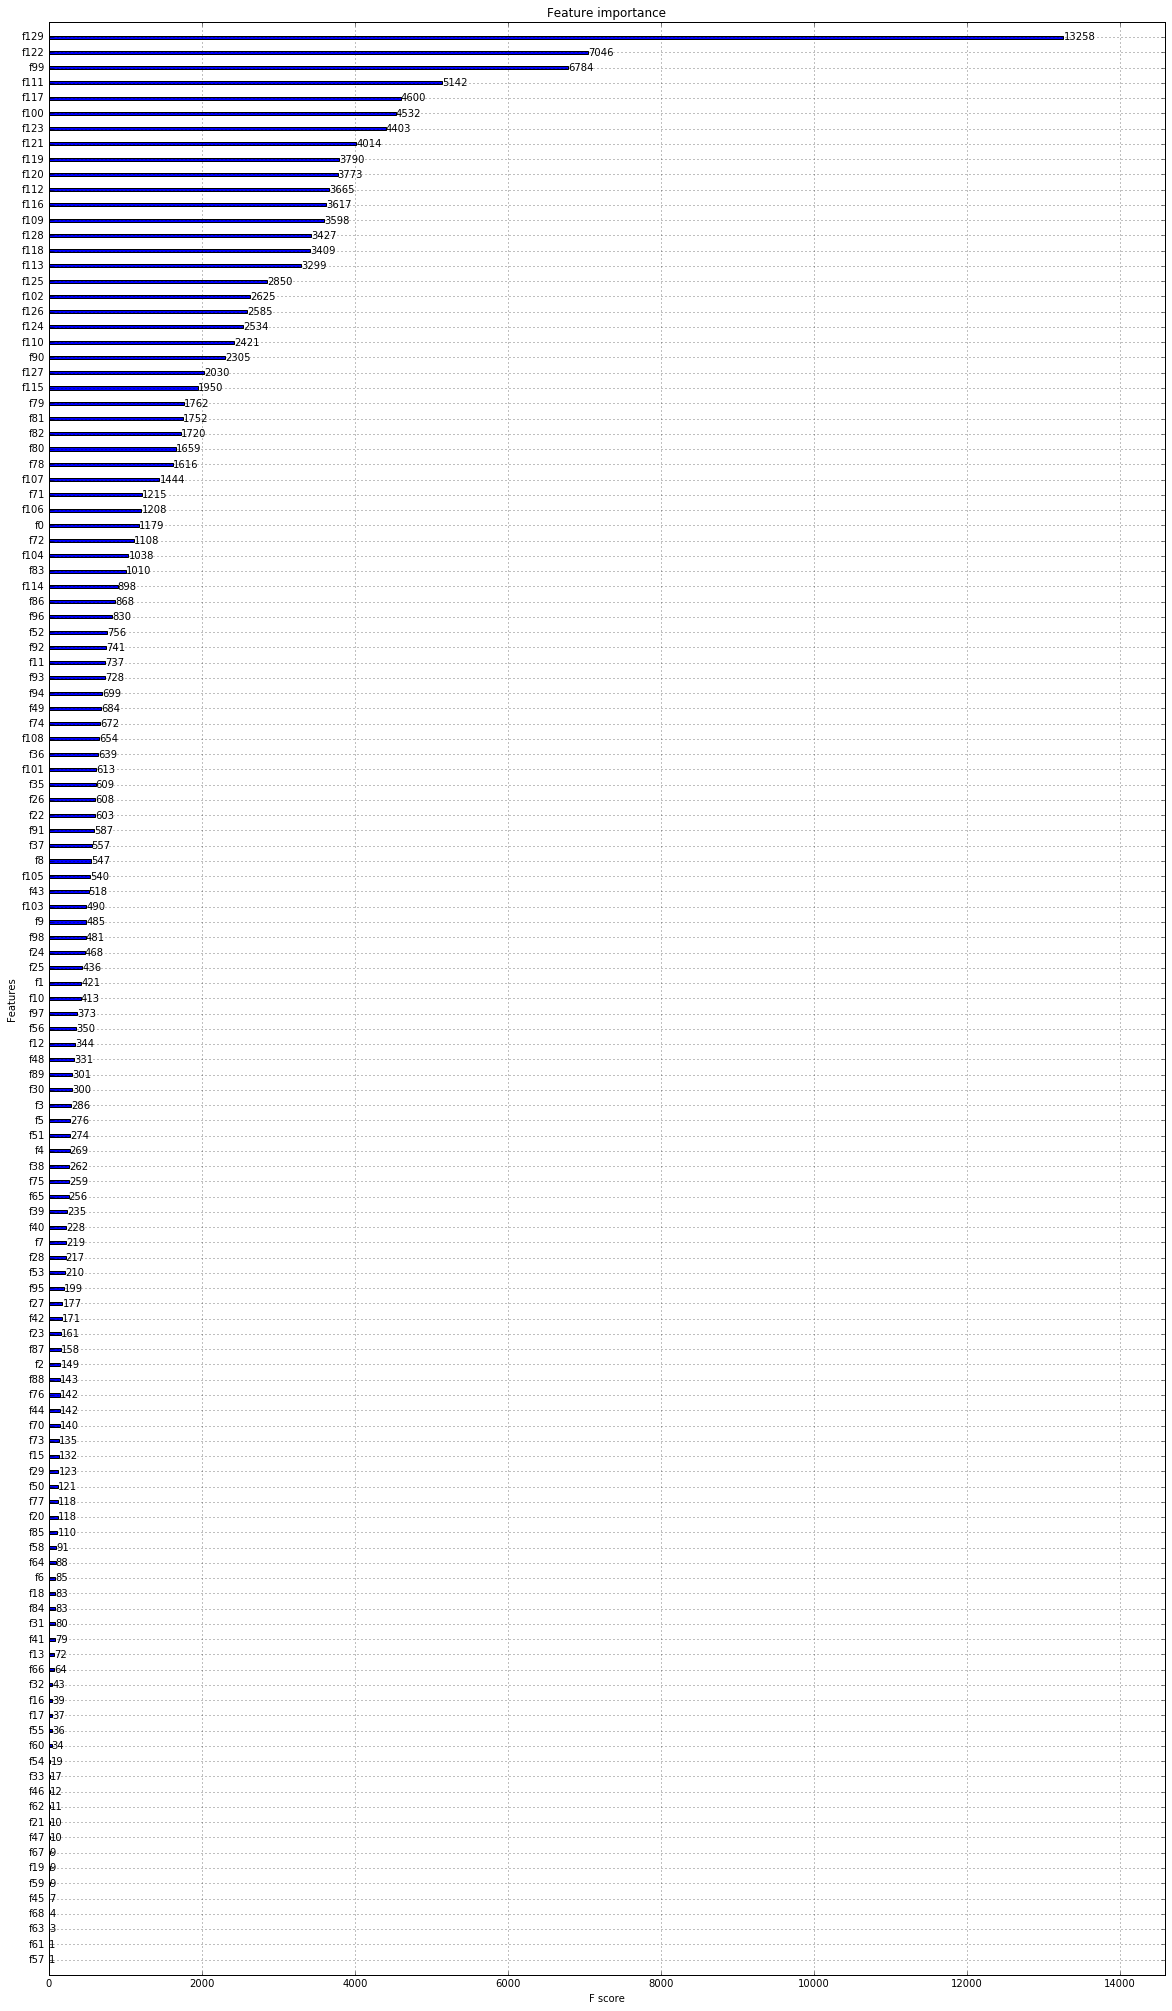

In [43]:
fig = plt.figure(figsize=(20,35))

xgb.plot_importance(gbt,ax = fig.gca() );

In [44]:
# y_pred_i = gbt.predict(d_test_xgb)
# y_pred.append(lossRestore(y_pred_i,ymean,ystd))
# y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))
y_pred_i = gbt.predict(d_test_xgb)
y_pred.append(y_pred_i)
y_pred_val.append(gbt.predict(x_val_xgb))

modelList.append(gbt)

# crossplotting y_val vs. y_predictions

In [59]:
# average the results
y_pred_val_avg = np.mean(y_pred_val,axis=0)
y_pred_val_avg

array([ 0.35021824,  0.47028523,  0.56789917, ...,  0.28916016,
        0.39232379,  0.32585384])

In [60]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(y_pred_val_avg,ymean,ystd)))

1141.15920967


(0, 23000)

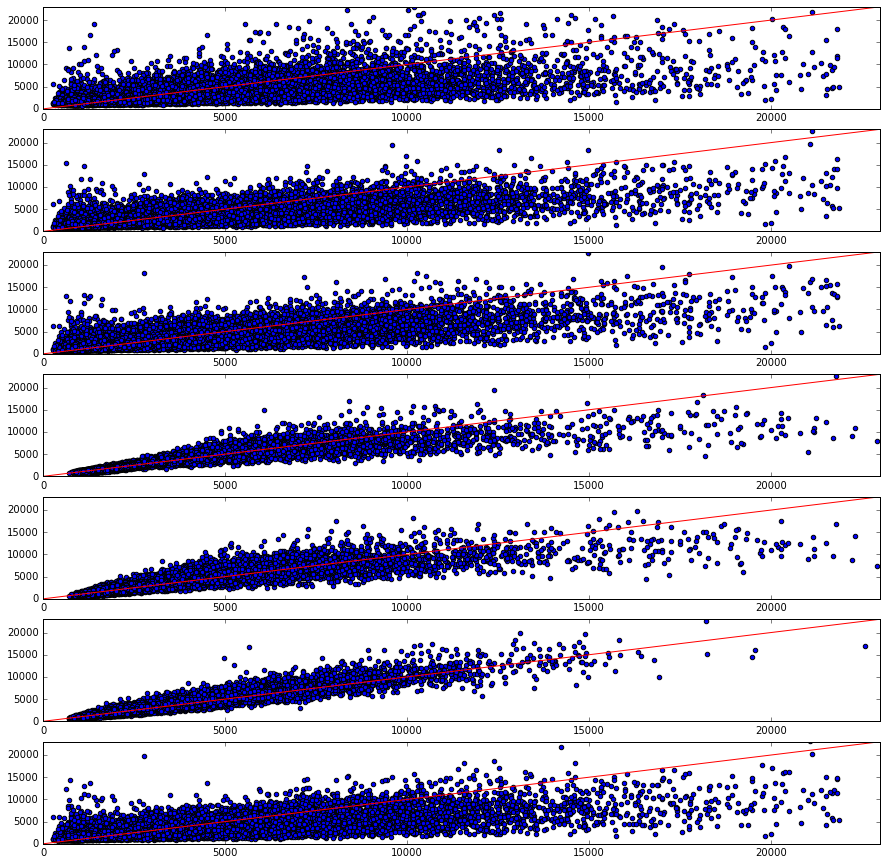

In [64]:
xlim = [0,23000]
ylim = [0,23000]
plt.figure(figsize=(15,15))
plt.subplot(7,1,1)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_pred_val[0],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,2)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_pred_val[1],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,3)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_pred_val[2],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,4)
plt.scatter(lossRestore(y_pred_val[0],ymean,ystd),lossRestore(y_pred_val[1],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,5)
plt.scatter(lossRestore(y_pred_val[0],ymean,ystd),lossRestore(y_pred_val[2],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,6)
plt.scatter(lossRestore(y_pred_val[1],ymean,ystd),lossRestore(y_pred_val[2],ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)
plt.subplot(7,1,7)
plt.scatter(lossRestore(y_val,ymean,ystd),lossRestore(y_pred_val_avg,ymean,ystd));
plt.plot([0,23000],[0,23000],'r');
plt.ylim(ylim)
plt.xlim(xlim)

# save files for submission

In [45]:
# # remove the shift
# y_pred = [y_array-shift for y_array in y_pred];
# y_pred_val_en = [y_array-shift for y_array in y_pred_val_en];

In [46]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [113]:
from sklearn.externals import joblib
joblib.dump(testList
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-testList.pkl',compress=3) 

joblib.dump(y_pred
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_pred.pkl',compress=3) 

joblib.dump(y_pred_val
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_pred_val.pkl',compress=3)

joblib.dump(x_train
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-x_train.pkl',compress=3) 

joblib.dump(x_val
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-x_val.pkl',compress=3) 

joblib.dump(y_train
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_train.pkl',compress=3) 

joblib.dump(y_val
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_val.pkl',compress=3) 

joblib.dump(x_test
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-x_test.pkl',compress=3) 

joblib.dump([shift,ymean,ystd]
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-shift.pkl',compress=3) 

['../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-shift.pkl']

In [114]:
y_pred_train = []
for model in modelList[0:2]:
    y_pred_train.append(model.predict(x_train))
y_pred_train.append(gbt.predict(d_train_xgb))
y_pred_train

[array([ 0.32237208,  0.36055518,  0.31823752, ...,  0.4053973 ,
         0.31369783,  0.49722094]),
 array([ 0.31266729,  0.3408666 ,  0.32724948, ...,  0.40988582,
         0.25054019,  0.50098333]),
 array([ 0.33328658,  0.32791865,  0.32785732, ...,  0.4206571 ,
         0.24092638,  0.47257465], dtype=float32)]

In [115]:
joblib.dump(y_pred_train
            ,'../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_pred_train.pkl',compress=3) 

['../output/0001-00-ebsemble-ordsortedABC-rawcont-logloss-clipped-y_pred_train.pkl']